In [1]:
import random
import numpy as np
from futu import *
import pandas as pd 
from queue import Queue
from quant.data.sqlitedatahandler import SQLiteDataHandler
from quant.backtest import Backtest

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, KernelPCA

plate = ['HK.BK1001', 'HK.BK1002', 'HK.BK1003', 'HK.BK1004', 'HK.BK1005', 'HK.BK1007', 'HK.BK1008', 'HK.BK1009', 
         'HK.BK1010', 'HK.BK1011', 'HK.BK1012', 'HK.BK1013', 'HK.BK1014', 'HK.BK1015', 'HK.BK1016', 'HK.BK1017', 
         'HK.BK1019', 'HK.BK1020', 'HK.BK1021', 'HK.BK1022', 'HK.BK1025', 'HK.BK1026', 'HK.BK1027', 'HK.BK1028', 
         'HK.BK1029', 'HK.BK1030', 'HK.BK1031', 'HK.BK1032', 'HK.BK1033', 'HK.BK1034', 'HK.BK1035', 'HK.BK1037', 
         'HK.BK1039', 'HK.BK1040', 'HK.BK1041', 'HK.BK1042', 'HK.BK1043', 'HK.BK1044', 'HK.BK1045', 'HK.BK1046', 
         'HK.BK1047', 'HK.BK1048', 'HK.BK1049', 'HK.BK1050', 'HK.BK1051', 'HK.BK1052', 'HK.BK1053', 'HK.BK1054', 
         'HK.BK1055', 'HK.BK1056', 'HK.BK1058', 'HK.BK1059', 'HK.BK1061', 'HK.BK1062', 'HK.BK1063', 'HK.BK1064', 
         'HK.BK1065', 'HK.BK1066', 'HK.BK1067', 'HK.BK1068', 'HK.BK1069', 'HK.BK1070', 'HK.BK1071', 'HK.BK1072', 
         'HK.BK1073', 'HK.BK1074', 'HK.BK1075', 'HK.BK1076', 'HK.BK1077', 'HK.BK1078', 'HK.BK1079', 'HK.BK1080', 
         'HK.BK1082', 'HK.BK1083', 'HK.BK1084', 'HK.BK1086', 'HK.BK1087', 'HK.BK1089', 'HK.BK1090', 'HK.BK1091', 
         'HK.BK1093', 'HK.BK1094', 'HK.BK1095', 'HK.BK1096', 'HK.BK1097', 'HK.BK1098', 'HK.BK1099', 'HK.BK1100']

events = Queue()
sdh = SQLiteDataHandler(plate, events, '2020-01-01', sqllite_db="test1.db")

2020-05-31 20:14:08,572 [open_context_base.py] _socket_reconnect_and_wait_ready:257: Start connecting: host=127.0.0.1; port=11111;
2020-05-31 20:14:08,574 [open_context_base.py] on_connected:346: Connected : conn_id=1; 
2020-05-31 20:14:08,576 [open_context_base.py] _handle_init_connect:447: InitConnect ok: conn_id=1; info={'server_version': 212, 'login_user_id': 7659870, 'conn_id': 6672832522403567374, 'conn_key': '8AFA59A9B190F463', 'conn_iv': 'CA9678AE7FE44695', 'keep_alive_interval': 10, 'is_encrypt': False};


start sqlite ...
start futu ...


In [2]:
sdh.update_local_kline_db()
sdh.load_kline_from_local_db()
sdh.init_hist_time_line()
sdh.load_basicinfo_from_local_db()

In [359]:
ret, bmk = {}, None
for code in sdh.hist_kline:
    df = sdh.hist_kline[code]
    if code == sdh.benchmark:
        bmk =  100 * (df.close - df.last_close) / df.last_close
    else:
        ret[code] = 100 * (df.close - df.last_close) / df.last_close

bmk = bmk['2019-06-01':'2020-05-31']
data = pd.DataFrame(ret)['2019-06-01':'2020-05-31']

XY = pd.DataFrame((data.values * bmk.values.reshape(-1,1)).mean(axis=0), 
                  index=data.columns, columns=["XY_cor"])

XY["Y_avg"] = data.mean()
XY["Y_std"] = data.std()

XY["X_avg"] = bmk.mean()
XY["X_var"] = bmk.var()
XY["X_std"] = bmk.std()
XY["XY_cor"] -= XY["X_avg"] * XY["Y_avg"]


XY['beta'] = XY["XY_cor"] / XY["X_var"]
XY['alpha'] = XY["Y_avg"] - XY['beta'] * XY["X_avg"]
XY['X_sharpe'] = XY["X_avg"] / XY["X_std"]
XY['Y_sharpe'] = XY["Y_avg"] / XY["Y_std"]
XY['ratio'] = XY['Y_sharpe'] / XY['X_sharpe'] 

XY = XY[['beta', 'alpha', 'X_sharpe', 'Y_sharpe','ratio']]
XY

,beta,alpha,X_sharpe,Y_sharpe,ratio
HK.BK1037,0.177761,-0.037548,-0.038439,-0.028026,0.729105
HK.BK1046,0.488096,-0.074556,-0.038439,-0.080949,2.105890
HK.BK1053,1.001120,0.014677,-0.038439,-0.020410,0.530960
HK.BK1073,0.886383,-0.091172,-0.038439,-0.083997,2.185187
HK.BK1009,0.479167,-0.068267,-0.038439,-0.081090,2.109571
...,...,...,...,...,...
HK.BK1039,0.676363,-0.007631,-0.038439,-0.030966,0.805587
HK.BK1054,0.876565,-0.060760,-0.038439,-0.063048,1.640208
HK.BK1064,1.144501,-0.085904,-0.038439,-0.071673,1.864589
HK.BK1005,0.863295,-0.050773,-0.038439,-0.060036,1.561853


In [360]:
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
%matplotlib inline
cnames = {
'aliceblue':            '#F0F8FF',
'antiquewhite':         '#FAEBD7',
'aqua':                 '#00FFFF',
'aquamarine':           '#7FFFD4',
'azure':                '#F0FFFF',
'beige':                '#F5F5DC',
'bisque':               '#FFE4C4',
'black':                '#000000',
'blanchedalmond':       '#FFEBCD',
'blue':                 '#0000FF',
'blueviolet':           '#8A2BE2',
'brown':                '#A52A2A',
'burlywood':            '#DEB887',
'cadetblue':            '#5F9EA0',
'chartreuse':           '#7FFF00',
'chocolate':            '#D2691E',
'coral':                '#FF7F50',
'cornflowerblue':       '#6495ED',
'cornsilk':             '#FFF8DC',
'crimson':              '#DC143C',
'cyan':                 '#00FFFF',
'darkblue':             '#00008B',
'darkcyan':             '#008B8B',
'darkgoldenrod':        '#B8860B',
'darkgray':             '#A9A9A9',
'darkgreen':            '#006400',
'darkkhaki':            '#BDB76B',
'darkmagenta':          '#8B008B',
'darkolivegreen':       '#556B2F',
'darkorange':           '#FF8C00',
'darkorchid':           '#9932CC',
'darkred':              '#8B0000',
'darksalmon':           '#E9967A',
'darkseagreen':         '#8FBC8F',
'darkslateblue':        '#483D8B',
'darkslategray':        '#2F4F4F',
'darkturquoise':        '#00CED1',
'darkviolet':           '#9400D3',
'deeppink':             '#FF1493',
'deepskyblue':          '#00BFFF',
'dimgray':              '#696969',
'dodgerblue':           '#1E90FF',
'firebrick':            '#B22222',
'floralwhite':          '#FFFAF0',
'forestgreen':          '#228B22',
'fuchsia':              '#FF00FF',
'gainsboro':            '#DCDCDC',
'ghostwhite':           '#F8F8FF',
'gold':                 '#FFD700',
'goldenrod':            '#DAA520',
'gray':                 '#808080',
'green':                '#008000',
'greenyellow':          '#ADFF2F',
'honeydew':             '#F0FFF0',
'hotpink':              '#FF69B4',
'indianred':            '#CD5C5C',
'indigo':               '#4B0082',
'ivory':                '#FFFFF0',
'khaki':                '#F0E68C',
'lavender':             '#E6E6FA',
'lavenderblush':        '#FFF0F5',
'lawngreen':            '#7CFC00',
'lemonchiffon':         '#FFFACD',
'lime':                 '#00FF00',
'limegreen':            '#32CD32',
'linen':                '#FAF0E6',
'magenta':              '#FF00FF',
'maroon':               '#800000',
'mediumaquamarine':     '#66CDAA',
'mediumblue':           '#0000CD',
'mediumorchid':         '#BA55D3',
'mediumpurple':         '#9370DB',
'mediumseagreen':       '#3CB371',
'mediumslateblue':      '#7B68EE',
'mediumspringgreen':    '#00FA9A',
'mediumturquoise':      '#48D1CC',
'mediumvioletred':      '#C71585',
'midnightblue':         '#191970',
'mintcream':            '#F5FFFA',
'mistyrose':            '#FFE4E1',
'moccasin':             '#FFE4B5',
'navajowhite':          '#FFDEAD',
'navy':                 '#000080',
'oldlace':              '#FDF5E6',
'olive':                '#808000',
'olivedrab':            '#6B8E23',
'orange':               '#FFA500',
'orangered':            '#FF4500',
'orchid':               '#DA70D6',
'palegoldenrod':        '#EEE8AA',
'palegreen':            '#98FB98',
'paleturquoise':        '#AFEEEE',
'palevioletred':        '#DB7093',
'papayawhip':           '#FFEFD5',
'peachpuff':            '#FFDAB9',
'peru':                 '#CD853F',
'pink':                 '#FFC0CB',
'plum':                 '#DDA0DD',
'powderblue':           '#B0E0E6',
'purple':               '#800080',
'red':                  '#FF0000',
'rosybrown':            '#BC8F8F',
'royalblue':            '#4169E1',
'saddlebrown':          '#8B4513',
'salmon':               '#FA8072',
'sandybrown':           '#FAA460',
'seagreen':             '#2E8B57',
'seashell':             '#FFF5EE',
'sienna':               '#A0522D',
'silver':               '#C0C0C0',
'skyblue':              '#87CEEB',
'slateblue':            '#6A5ACD',
'slategray':            '#708090',
'snow':                 '#FFFAFA',
'springgreen':          '#00FF7F',
'steelblue':            '#4682B4',
'tan':                  '#D2B48C',
'teal':                 '#008080',
'thistle':              '#D8BFD8',
'tomato':               '#FF6347',
'turquoise':            '#40E0D0',
'violet':               '#EE82EE',
'wheat':                '#F5DEB3',
'white':                '#FFFFFF',
'whitesmoke':           '#F5F5F5',
'yellow':               '#FFFF00',
'yellowgreen':          '#9ACD32'
}

def rand_color(k):
    selected = [key for key in cnames if 'F' not in cnames[key]]
    return random.sample(selected, k=k)
    
plt.figure(figsize=(30,20))


def analyze(Y):
    plates = data.columns.tolist()
    ret, df_plates = sdh.quote_ctx.get_plate_list(Market.HK, Plate.INDUSTRY)
    df_plates.set_index('code', inplace=True)


    cata = {}
    for i, j in enumerate(Y):
        plate_name = df_plates.loc[plates[i]].plate_name
        if j not in cata:
            cata[j] = [plate_name]
        else:
            cata[j].append(plate_name)

    for i in range(len(cata)):
        print(i, len(cata[i]), cata[i])
        print()

<Figure size 2160x1440 with 0 Axes>

88


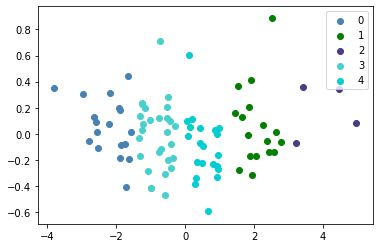

0 18 ['信贷', '投资及资管', '综合企业', '医疗及医美', '房地产信托', '酒店度假村', '化肥农药', '广告及宣传', '钢铁', '建筑服务', '文体休闲用品', '航运及港口', '影视娱乐', '印刷包装', '地产投资', '旅游观光', '百货商城', '支援服务']

1 17 ['建筑工程', '餐饮', '应用软件', '工业器材', '殡仪服务', '黄金贵金属', '家庭电器', '电商及互联网', '其他金融', '酒精饮料', '建筑材料', '重机械', '农业产品', '半导体', '美容护理', '食品添加剂', '教育']

2 4 ['物业管理', '系统软件', '医疗设备', '超市便利店']

3 28 ['特殊化工品', '重型基建', '出版', '汽车零件', '银行', '供应链管理', '煤炭', '广播', '铜', '铁路公路', '珠宝钟表', '油气生产商', '航空物流', '油气设备', '非酒精饮料', '卫星通讯', '可再生能源', '电力', '商业用车', '地产代理', '保险', '铝', '文娱设施', '航天军工', '装修与设计', '电讯服务', '航空服务', '公共运输']

4 21 ['林业木材', '电脑器材', '纺织服饰', '乳制品', '生物科技', '包装食品', '电话设备及元件', '燃气供应', '资讯科技服务', '药品', '证券经纪', '纸及纸制品', '电子消费品', '家具', '汽车', '环保工程', '游戏软件', '新能源物料', '地产发展商', '博彩概念', '水务']



In [369]:
pca = PCA(n_components=2)
X = pca.fit(XY).transform(XY)

num_cluster = 5
kmeans = KMeans(n_clusters=num_cluster)
kmeans.fit(XY)
Y = kmeans.labels_

print(len(Y))

for i, color in enumerate(rand_color(num_cluster)):
    plt.scatter(X[Y == i, 0], X[Y == i, 1], color=color, label=i)

plt.legend()
plt.show()
analyze(Y)

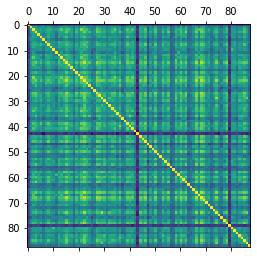

In [362]:
pearson = data.corr(method='pearson', min_periods=1)
plt.matshow(pearson.values)

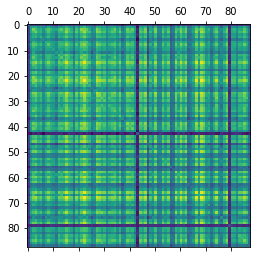

In [363]:
# denoise
cor = pearson.values - np.eye(len(pearson.values))
eigenvalue, featurevector=np.linalg.eig(cor)

eigenvalue[eigenvalue<0] = 0

recom = np.dot(np.dot(featurevector, np.diag(eigenvalue)), featurevector.T)

plt.matshow(recom)
#plt.plot(eigenvalue)

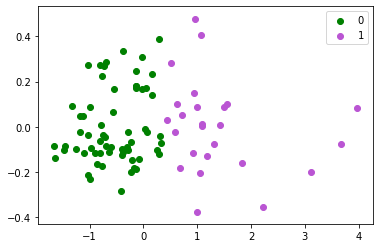

0 63 ['特殊化工品', '电脑器材', '重型基建', '出版', '纺织服饰', '乳制品', '汽车零件', '生物科技', '餐饮', '包装食品', '电话设备及元件', '燃气供应', '银行', '资讯科技服务', '信贷', '投资及资管', '物业管理', '工业器材', '综合企业', '药品', '煤炭', '证券经纪', '铜', '房地产信托', '铁路公路', '珠宝钟表', '纸及纸制品', '电子消费品', '家具', '油气生产商', '家庭电器', '油气设备', '电商及互联网', '酒店度假村', '化肥农药', '汽车', '钢铁', '环保工程', '可再生能源', '酒精饮料', '建筑材料', '电力', '游戏软件', '航运及港口', '新能源物料', '商业用车', '影视娱乐', '地产发展商', '半导体', '保险', '铝', '印刷包装', '美容护理', '航天军工', '地产投资', '百货商城', '博彩概念', '食品添加剂', '教育', '水务', '电讯服务', '航空服务', '公共运输']

1 25 ['林业木材', '建筑工程', '应用软件', '供应链管理', '医疗及医美', '广播', '殡仪服务', '黄金贵金属', '航空物流', '非酒精饮料', '其他金融', '广告及宣传', '系统软件', '卫星通讯', '建筑服务', '文体休闲用品', '重机械', '农业产品', '地产代理', '文娱设施', '旅游观光', '医疗设备', '装修与设计', '支援服务', '超市便利店']



In [364]:
pca = PCA(n_components=2)
X = pca.fit(recom).transform(recom)

num_cluster = 2
kmeans = KMeans(n_clusters=num_cluster)
kmeans.fit(recom)
Y = kmeans.labels_


for i, color in enumerate(rand_color(num_cluster)):
    plt.scatter(X[Y == i, 0], X[Y == i, 1], color=color, label=i)

plt.legend()
plt.show()
analyze(Y)

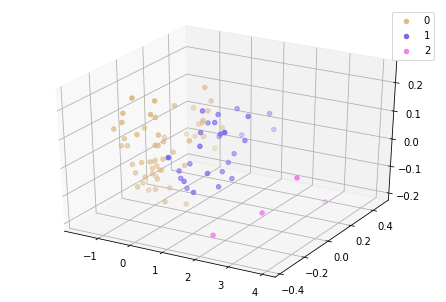

0 56 ['电脑器材', '重型基建', '出版', '纺织服饰', '乳制品', '汽车零件', '生物科技', '包装食品', '电话设备及元件', '燃气供应', '银行', '资讯科技服务', '信贷', '投资及资管', '工业器材', '综合企业', '药品', '煤炭', '证券经纪', '铜', '房地产信托', '铁路公路', '珠宝钟表', '纸及纸制品', '电子消费品', '油气生产商', '家庭电器', '油气设备', '电商及互联网', '酒店度假村', '化肥农药', '汽车', '钢铁', '环保工程', '可再生能源', '酒精饮料', '建筑材料', '电力', '游戏软件', '航运及港口', '新能源物料', '商业用车', '地产发展商', '保险', '铝', '美容护理', '航天军工', '地产投资', '百货商城', '博彩概念', '食品添加剂', '教育', '水务', '电讯服务', '航空服务', '公共运输']

1 28 ['特殊化工品', '建筑工程', '餐饮', '应用软件', '供应链管理', '物业管理', '医疗及医美', '广播', '殡仪服务', '家具', '黄金贵金属', '航空物流', '非酒精饮料', '系统软件', '卫星通讯', '建筑服务', '文体休闲用品', '重机械', '农业产品', '地产代理', '影视娱乐', '半导体', '印刷包装', '文娱设施', '旅游观光', '医疗设备', '支援服务', '超市便利店']

2 4 ['林业木材', '其他金融', '广告及宣传', '装修与设计']



In [365]:
pca = PCA(n_components=3)
X = pca.fit(recom).transform(recom)

num_cluster = 3
kmeans = KMeans(n_clusters=num_cluster)
kmeans.fit(recom)
Y = kmeans.labels_

fig = plt.figure()
axes3d = Axes3D(fig)
for i, color in enumerate(rand_color(num_cluster)):
    axes3d.scatter(X[Y == i, 0], X[Y == i, 1], X[Y == i, 2], color=color, label=i)

plt.legend()
plt.show()
analyze(Y)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/extmath.py:530: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]
/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/_spectral.py:482: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


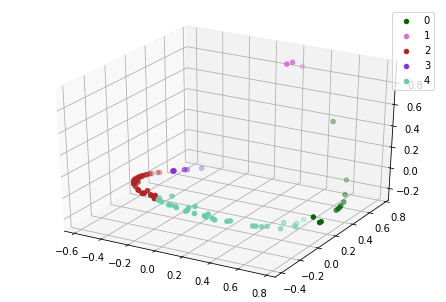

0 11 ['供应链管理', '黄金贵金属', '广告及宣传', '建筑服务', '文体休闲用品', '重机械', '农业产品', '地产代理', '文娱设施', '支援服务', '超市便利店']

1 3 ['林业木材', '其他金融', '装修与设计']

2 39 ['电脑器材', '重型基建', '纺织服饰', '汽车零件', '包装食品', '电话设备及元件', '燃气供应', '资讯科技服务', '信贷', '投资及资管', '工业器材', '药品', '煤炭', '证券经纪', '铜', '铁路公路', '珠宝钟表', '纸及纸制品', '电子消费品', '油气生产商', '家庭电器', '油气设备', '电商及互联网', '酒店度假村', '化肥农药', '汽车', '环保工程', '可再生能源', '建筑材料', '电力', '航运及港口', '新能源物料', '商业用车', '铝', '地产投资', '百货商城', '博彩概念', '水务', '航空服务']

3 4 ['银行', '综合企业', '地产发展商', '保险']

4 31 ['特殊化工品', '出版', '建筑工程', '乳制品', '生物科技', '餐饮', '应用软件', '物业管理', '医疗及医美', '广播', '房地产信托', '殡仪服务', '家具', '航空物流', '非酒精饮料', '钢铁', '系统软件', '卫星通讯', '酒精饮料', '游戏软件', '影视娱乐', '半导体', '印刷包装', '美容护理', '航天军工', '旅游观光', '医疗设备', '食品添加剂', '教育', '电讯服务', '公共运输']



In [297]:
kpca = KernelPCA(n_components=3, kernel="rbf", fit_inverse_transform=True, gamma=0.5)
X = kpca.fit_transform(recom)

from sklearn.cluster import SpectralClustering

num_cluster = 5
spectralClustering = SpectralClustering(n_clusters=num_cluster, affinity='rbf', gamma=20)
spectralClustering.fit(recom)
Y = spectralClustering.labels_

fig = plt.figure()
axes3d = Axes3D(fig)
for i, color in enumerate(rand_color(num_cluster)):
    axes3d.scatter(X[Y == i, 0], X[Y == i, 1], X[Y == i, 2], color=color, label=i)

plt.legend()
plt.show()
analyze(Y)

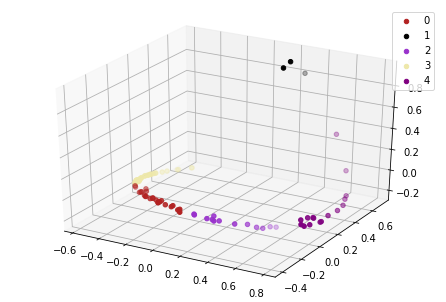

0 26 ['出版', '纺织服饰', '乳制品', '生物科技', '包装食品', '电话设备及元件', '燃气供应', '资讯科技服务', '信贷', '煤炭', '房地产信托', '珠宝钟表', '纸及纸制品', '化肥农药', '钢铁', '酒精饮料', '游戏软件', '新能源物料', '美容护理', '航天军工', '百货商城', '食品添加剂', '教育', '水务', '电讯服务', '公共运输']

1 3 ['林业木材', '其他金融', '装修与设计']

2 13 ['特殊化工品', '餐饮', '物业管理', '广播', '殡仪服务', '家具', '航空物流', '非酒精饮料', '系统软件', '影视娱乐', '半导体', '印刷包装', '旅游观光']

3 30 ['电脑器材', '重型基建', '汽车零件', '银行', '投资及资管', '工业器材', '综合企业', '药品', '证券经纪', '铜', '铁路公路', '电子消费品', '油气生产商', '家庭电器', '油气设备', '电商及互联网', '酒店度假村', '汽车', '环保工程', '可再生能源', '建筑材料', '电力', '航运及港口', '商业用车', '地产发展商', '保险', '铝', '地产投资', '博彩概念', '航空服务']

4 16 ['建筑工程', '应用软件', '供应链管理', '医疗及医美', '黄金贵金属', '广告及宣传', '卫星通讯', '建筑服务', '文体休闲用品', '重机械', '农业产品', '地产代理', '文娱设施', '医疗设备', '支援服务', '超市便利店']



In [366]:
kpca = KernelPCA(n_components=3, kernel="rbf", fit_inverse_transform=True, gamma=0.5)
X = kpca.fit_transform(recom)

from sklearn.cluster import SpectralClustering

num_cluster = 5
kmeans = KMeans(n_clusters=num_cluster)
kmeans.fit(recom)
Y = kmeans.labels_

fig = plt.figure()
axes3d = Axes3D(fig)
for i, color in enumerate(rand_color(num_cluster)):
    axes3d.scatter(X[Y == i, 0], X[Y == i, 1], X[Y == i, 2], color=color, label=i)

plt.legend()
plt.show()
analyze(Y)